<a href="https://colab.research.google.com/gist/KhawajaMuddassar/c99b06c01caf76124e6e500ebc9db08f/copy-of-cineface-1-0-actors-face-dcgan-using-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
!pip install kaggle
!pip install --upgrade kagglehub

import kagglehub
dmitriypushkarev_cineface10_path = kagglehub.dataset_download('dmitriypushkarev/cineface10')
print(dmitriypushkarev_cineface10_path)
print('Data source import complete.')

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


# CineFace 1.0 - Actors Face DCGAN using PyTorch

## Introduction

**Project Description**

1. What type of data is been used in this project?

In this project, we will be using image data, this data is stored on kaggle you can check it over [here](https://www.kaggle.com/datasets/dmitriypushkarev/cineface10). The image data contains images of famous cinema actors and actresses, there are total of 44,765 files of 1,279 people around 35 face images per person. The width and height of the image is 299px.

2. What type of problem we are solving in this project?

In this project we will be implementing Generative Adversarial Networks(GANs), a unsupervised neural network algorithm architecture in the field of computer vision. GANs are based on a simple concept to generate similar but fake data out of the real/original data. Recently, GANs have become the best method in mimicking objects in a very convincing way.

* **Objective** - Task for this project is to experiment and generate fake images of the the cinema actors and actresses.

* **Methodology** - We will be using the Deep Convolutional Generative Adversarial Network(DCGAN) architecture, as in the name we will be using convolutional layers in our neural networks. This methodology is the basic among the different types of GANs, understanding and implementing this architecture gives a strong foundation in GANs. PyTorch has a great [tutorial on DCGAN](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html), check this tutorial for much more indepth learning.

## Importing Libraries

In [2]:
# Importing all the necessary libraries

# Installing modules that are not pre-installed
!pip install torchinfo --upgrade --quiet

# libraries for project workflow
import os
from pathlib import Path
import shutil
from tqdm import tqdm
import numpy as np
import cv2

# libraries for visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# libraries for tensor manipulation
import torch
from torchinfo import summary
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid, save_image

## Dataset

In [10]:
# Defining the image directory
image_data_dir = Path('/kaggle/input/cineface10/CineFace1.0')

# Checking the files in the data directory
print(f'Face image directory: {image_data_dir}')
print(f'Number of images in the monet directory: {len(os.listdir(image_data_dir / "CineFace1.0"))}')

Face image directory: /kaggle/input/cineface10/CineFace1.0
Number of images in the monet directory: 44765


## Creating Dataset and DataLoader

We will load the dataset using the ImageFolder class from torchvision. We will also apply transforms like Resize and CenterCrop.

Also, we will normalize the image at 0.5 for mean and standard deviation. This will make sure that we recive the data in the range of -1 and 1 which is best for training the models.

Finally, we create the dataloader to load the data in the form of batches.

In [11]:
# Creating a helper function for random seed
def seed(n: int=42):
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
seed(42)

In [12]:
# input values
image_size = 64
batch_size = 128
mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
workers = os.cpu_count()

# Creating dataset
dataset = ImageFolder(root=image_data_dir,
                      transform=transforms.Compose([
                          transforms.Resize(image_size),
                          transforms.CenterCrop(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=mean, std=std)
                      ]))

# Creating dataloader
seed(42)
dataloader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=workers,
                        pin_memory=True)

print('Images in dataset:', len(dataset), 'and Batch in dataloader:', len(dataloader))

Images in dataset: 44765 and Batch in dataloader: 350


In [13]:
# Creating device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

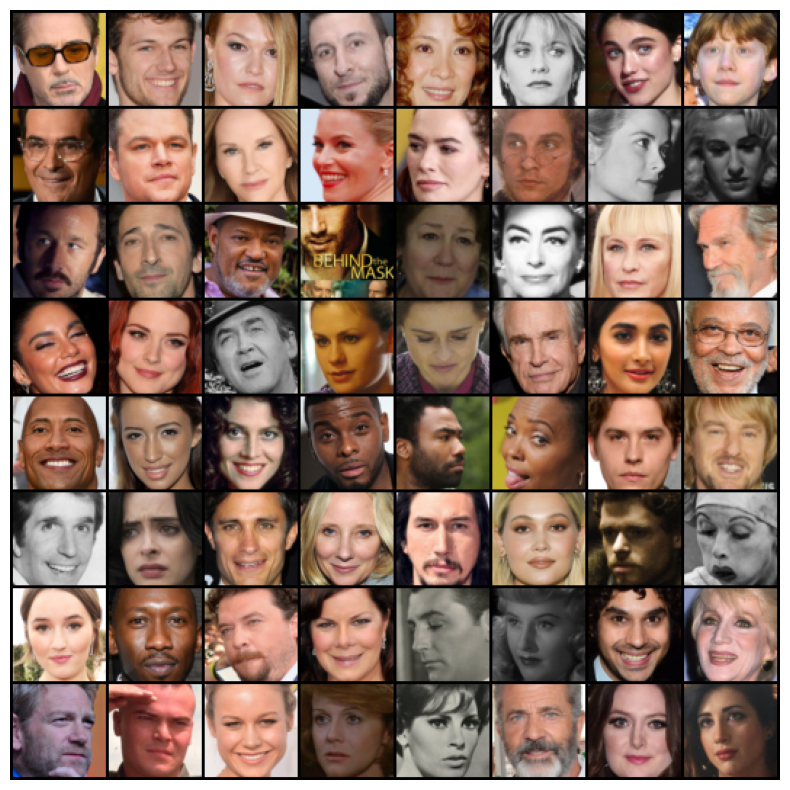

In [14]:
# Creating a helper function to plot images in grid
def plot_grid_images(images, nmax=64, nrow=8):
    plt.figure(figsize=(10, 10))
    plt.imshow(make_grid(images.to(device)[:nmax], nrow=nrow, normalize=True).permute(1, 2, 0).cpu())
    plt.axis(False)

def plot_dataloader_images(dataloader, nmax=64, nrow=8):
    images,_ = next(iter(dataloader))
    plot_grid_images(images=images, nmax=nmax, nrow=nrow)

plot_dataloader_images(dataloader)

## Modeling

Now, that we have our dataset and dataloaders ready for the experiment, we can move forward and work on the modeling.

![](https://machinelearningmastery.com/wp-content/uploads/2019/04/Example-of-the-Generative-Adversarial-Network-Model-Architecture.png)

*GANs Architecture*

GANs are based on two different models namely Discriminator and Generator. The Generator generates 'Fake' samples out of a random vector or matrix and the Discriminator attempts to detects whether the given sample is 'Real' or 'Fake'.

We train both the models and make them work together, this in exchange helps the Generator to create samples that can be exceptionally good and outsmart the Discriminator.

### Discrimination Architecture

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network.

We'll use a convolutional neural networks (CNN) which outputs a single number(between 0 and 1) for every image.

We'll use stride of 2 to progressively reduce the size of the output feature map.

In [15]:
# Creating discrimination network architecture
class Discriminator(nn.Module):
    def __init__(self, conv_dim=64):
        super().__init__()
        self.main = nn.Sequential(
            # in: 3 X 64 X 64
            nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 X 32 X 32

            nn.Conv2d(conv_dim, conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 X 16 X 16

            nn.Conv2d(conv_dim*2, conv_dim*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 X 8 X 8

            nn.Conv2d(conv_dim*4, conv_dim*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*8),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 X 4 X 4

            nn.Conv2d(conv_dim*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 X 1 X 1

            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Creating discriminator model
seed(42)
discriminator_model = Discriminator().to(device)
discriminator_model

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(

In [16]:
# Summary of the discriminator model
summary(model=discriminator_model,
        input_size=(batch_size, 3, image_size, image_size),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Discriminator (Discriminator)            [128, 3, 64, 64]     [128, 1]             --                   True
├─Sequential (main)                      [128, 3, 64, 64]     [128, 1]             --                   True
│    └─Conv2d (0)                        [128, 3, 64, 64]     [128, 64, 32, 32]    3,072                True
│    └─BatchNorm2d (1)                   [128, 64, 32, 32]    [128, 64, 32, 32]    128                  True
│    └─LeakyReLU (2)                     [128, 64, 32, 32]    [128, 64, 32, 32]    --                   --
│    └─Conv2d (3)                        [128, 64, 32, 32]    [128, 128, 16, 16]   131,072              True
│    └─BatchNorm2d (4)                   [128, 128, 16, 16]   [128, 128, 16, 16]   256                  True
│    └─LeakyReLU (5)                     [128, 128, 16, 16]   [128, 128, 16, 16]   --                   --
│    └─Conv2d (6) 

### Generator Architecture

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image.

The generator will convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 64 x 64. To achive this, we'll use the ConvTranspose2d layer from PyTorch, this layer performs a transposed convolution method on the matrix.

In [17]:
# Creating Generator architecture
class Generator(nn.Module):
    def __init__(self, latent_size: int, conv_dim=64):
        super().__init__()
        self.main = nn.Sequential(
            # in: latent_size X 1 X 1
            nn.ConvTranspose2d(latent_size, conv_dim*8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(conv_dim*8),
            nn.ReLU(inplace=True),
            # out: 512 X 4 X 4

            nn.ConvTranspose2d(conv_dim*8, conv_dim*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*4),
            nn.ReLU(inplace=True),
            # out: 256 X 8 X 8

            nn.ConvTranspose2d(conv_dim*4, conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*2),
            nn.ReLU(inplace=True),
            # out: 128 X 16 X 16

            nn.ConvTranspose2d(conv_dim*2, conv_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(inplace=True),
            # out: 64 X 32 X 32

            nn.ConvTranspose2d(conv_dim, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 X 64 X 64
        )
    def forward(self, input):
        return self.main(input)

# Creating the Generator model
seed(42)
# Using latent size of 128
latent_size = 128
generator_model = Generator(latent_size).to(device)
generator_model

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [18]:
# Summary of the generator model
summary(model=generator_model,
        input_size=(batch_size, latent_size, 1, 1),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Generator (Generator)                    [128, 128, 1, 1]     [128, 3, 64, 64]     --                   True
├─Sequential (main)                      [128, 128, 1, 1]     [128, 3, 64, 64]     --                   True
│    └─ConvTranspose2d (0)               [128, 128, 1, 1]     [128, 512, 4, 4]     1,048,576            True
│    └─BatchNorm2d (1)                   [128, 512, 4, 4]     [128, 512, 4, 4]     1,024                True
│    └─ReLU (2)                          [128, 512, 4, 4]     [128, 512, 4, 4]     --                   --
│    └─ConvTranspose2d (3)               [128, 512, 4, 4]     [128, 256, 8, 8]     2,097,152            True
│    └─BatchNorm2d (4)                   [128, 256, 8, 8]     [128, 256, 8, 8]     512                  True
│    └─ReLU (5)                          [128, 256, 8, 8]     [128, 256, 8, 8]     --                   --
│    └─ConvTranspo

Note: Since, we are using TanH activation in the Generator model the output values will lie in the range [-1,1], we have applied the similar transformation to the images in the training dataset.

Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

In [ ]:
# Apply random tensor of latent size to the generator model
seed(42)
x = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_image = generator_model(x)
print(fake_image.shape)
plot_grid_images(images=fake_image)

The output from the generator are random noices, because we haven't trained the model.

Once we train the model, this same random tensors will give results that are magical.

### Discriminator Training

The Discriminator is a binary classification model, so we can use the binary cross entropy for the loss function and know how well does the model differentiate between real and fake images.

In [20]:
# Creating a function for training the discriminator model
def train_discriminator(real_images, batch_size, latent_size, loss_fn, dis_opt):
    # zeroing gradients
    dis_opt.zero_grad()

    # Passing real images into the discriminator model
    real_preds = discriminator_model(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = loss_fn(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generating Fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator_model(latent)

    # Passing fake images into the discriminator model
    fake_preds = discriminator_model(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = loss_fn(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update the discriminator weights using the optimizer
    loss = real_loss + fake_loss
    loss.backward()
    dis_opt.step()
    return loss.item(), real_score, fake_score

Discriminator training explaination:

 1. We pass the real images to the discriminator and labels of ones as a ground truth to the loss function, we expect the discriminator to learn the real images.
 2. We then generate a batch of fake images and labels of zeros as a ground truth to the loss function, here we expect the discriminator to learn the generated images are fake.
 3. Next we add the losses of fake and real for which we perform gradient decent using the overall loss and adjust the weights of the model.

**Note:** We donot change the weights of the generator model, weights of discriminator model are only used durning gradient decent.

### Generator Training

In generator training, the only task is to create images that are similar or better than the real images and this real-like images should be capable to fool the discriminator.

In [21]:
# Creating a function for training the generator model
def train_generator(batch_size, latent_size, loss_fn, gen_opt):
    # Zeroing gradients
    gen_opt.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator_model(latent)

    # Passing the images to discriminator model
    preds = discriminator_model(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    loss = loss_fn(preds, targets)

    # Update the generator weights unsing the optimizer
    loss.backward()
    gen_opt.step()
    return loss.item()

Generator training explaination:

 1. We first generate a batch of random latent images of the given latent size, pass it to the model and the model generates fake images.
 2. We then pass the fake images to the discriminator model and perform the loss with the labels of torch.ones, this indicates that we are fooling the discriminator by letting it know that the images generated by the generator are not fake images, afterall the objective of the generator is to fool the discriminator.
 3. Then using the loss values we perform gradient decent and adjust the weights of the generator model. This method helps in improving the model to create images that are similar to real images.

In [22]:
# Creating a folder to contain all the images generated by the Generator
generator_img_dir = Path('generated')
if generator_img_dir.exists():
    print('[INFO] Generator image directory already exist.')
else:
    generator_img_dir.mkdir(parents=True, exist_ok=True)

In [23]:
# Creating a helper function that saves output of generated images
def save_generated_samples(index, latent_tensor, show=True, nrow=8, nmax=64):
    fake_images = generator_model(latent_tensor)
    fake_file_name = f'generated_images_{index:0=4d}.jpg'
    save_image(tensor=fake_images[:nmax], fp=generator_img_dir / fake_file_name, normalize=True, nrow=nrow)
    print(f'Saving {fake_file_name}\n')
    if show:
        plt.figure(figsize=(8, 8))
        plot_grid_images(images=fake_images, nrow=nrow, nmax=nmax)

We'll save a image using random tensor and check whether the helper function works the way we want.

In [ ]:
# Testing the helper function to save generated samples
random_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
save_generated_samples(0, random_latent)

### Training loop

We will now start training our Discriminator model and Generator Model for each batch of data.

The training flow will be initialized by Discriminator and follwing along with Generator, this way the Discriminator will help the Generator in creating perfect images.

We will also be using the Adam optimizer and Binary Cross Entropy Loss, and after every epochs we will also save some samples of generated images, this images will be helpful for model inspection.

Also durning the model training, we will use Weights and Biases to track our training.

In [25]:
# Creating a fit function for training the model
def fit(epochs, lr, beta1, device, batch_size, latent_size, start_idx=1):
    # Clearing GPU cache
    torch.cuda.empty_cache()

    # list for losses and scores
    gen_losses = []
    dis_losses = []
    real_scores = []
    fake_scores = []

    # Creating optimizer and loss
    loss_fn = nn.BCELoss()
    dis_opt = torch.optim.Adam(discriminator_model.parameters(), lr=lr, betas=(beta1, 0.999))
    gen_opt = torch.optim.Adam(generator_model.parameters(), lr=lr, betas=(beta1, 0.999))

    # Starting the model training
    for epoch in range(epochs):
        for real_images, _ in tqdm(dataloader):
            real_images = real_images.to(device)
            # Train discriminator model
            dis_loss, real_score, fake_score = train_discriminator(real_images=real_images,
                                                                   batch_size=batch_size,
                                                                   latent_size=latent_size,
                                                                   loss_fn=loss_fn,
                                                                   dis_opt=dis_opt)
            # train generator model
            gen_loss = train_generator(batch_size=batch_size,
                                       latent_size=latent_size,
                                       loss_fn=loss_fn,
                                       gen_opt=gen_opt)

        # Record losses and scores
        gen_losses.append(gen_loss)
        dis_losses.append(dis_loss)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Display losses and scores for every epoch
        print(f'Epoch: [{epoch+1}/{epochs}] | dis_loss: {dis_loss:.4f} | gen_loss: {gen_loss:.4f} | real_score: {real_score:.4f} | fake_score: {fake_score:.4f}')

        # Save generated image
        random_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        save_generated_samples(index=epoch+start_idx, latent_tensor=random_latent, show=False)
    return dis_losses, gen_losses, real_scores, fake_scores

We are now all set to train the model.

In [26]:
# Inputs for training model
epochs = 50
lr = 0.0002
beta1 = 0.5
history = fit(epochs=epochs,
              lr=lr,
              beta1=beta1,
              device=device,
              batch_size=batch_size,
              latent_size=latent_size)

100%|██████████| 350/350 [02:33<00:00,  2.28it/s]


Epoch: [1/50] | dis_loss: 0.1283 | gen_loss: 5.6800 | real_score: 0.9386 | fake_score: 0.0564
Saving generated_images_0001.jpg



100%|██████████| 350/350 [02:02<00:00,  2.86it/s]


Epoch: [2/50] | dis_loss: 0.1215 | gen_loss: 5.3057 | real_score: 0.9713 | fake_score: 0.0829
Saving generated_images_0002.jpg



100%|██████████| 350/350 [02:01<00:00,  2.87it/s]


Epoch: [3/50] | dis_loss: 0.2340 | gen_loss: 3.1132 | real_score: 0.8913 | fake_score: 0.1034
Saving generated_images_0003.jpg



100%|██████████| 350/350 [02:01<00:00,  2.87it/s]


Epoch: [4/50] | dis_loss: 0.2128 | gen_loss: 4.6415 | real_score: 0.8923 | fake_score: 0.0751
Saving generated_images_0004.jpg



100%|██████████| 350/350 [02:04<00:00,  2.82it/s]


Epoch: [5/50] | dis_loss: 0.6286 | gen_loss: 3.2250 | real_score: 0.6455 | fake_score: 0.0449
Saving generated_images_0005.jpg



100%|██████████| 350/350 [02:02<00:00,  2.85it/s]


Epoch: [6/50] | dis_loss: 0.3647 | gen_loss: 3.6774 | real_score: 0.8180 | fake_score: 0.1054
Saving generated_images_0006.jpg



100%|██████████| 350/350 [02:03<00:00,  2.83it/s]


Epoch: [7/50] | dis_loss: 0.5576 | gen_loss: 2.6262 | real_score: 0.6857 | fake_score: 0.0907
Saving generated_images_0007.jpg



100%|██████████| 350/350 [02:02<00:00,  2.85it/s]


Epoch: [8/50] | dis_loss: 0.3253 | gen_loss: 3.4262 | real_score: 0.8018 | fake_score: 0.0690
Saving generated_images_0008.jpg



100%|██████████| 350/350 [02:03<00:00,  2.83it/s]


Epoch: [9/50] | dis_loss: 0.4339 | gen_loss: 3.3176 | real_score: 0.8413 | fake_score: 0.1790
Saving generated_images_0009.jpg



100%|██████████| 350/350 [02:05<00:00,  2.78it/s]


Epoch: [10/50] | dis_loss: 0.2935 | gen_loss: 3.6355 | real_score: 0.8331 | fake_score: 0.0622
Saving generated_images_0010.jpg



100%|██████████| 350/350 [02:03<00:00,  2.84it/s]


Epoch: [11/50] | dis_loss: 0.2080 | gen_loss: 3.8333 | real_score: 0.9312 | fake_score: 0.1158
Saving generated_images_0011.jpg



100%|██████████| 350/350 [02:02<00:00,  2.86it/s]


Epoch: [12/50] | dis_loss: 0.6330 | gen_loss: 3.0524 | real_score: 0.6125 | fake_score: 0.0390
Saving generated_images_0012.jpg



100%|██████████| 350/350 [02:02<00:00,  2.85it/s]


Epoch: [13/50] | dis_loss: 1.3271 | gen_loss: 7.5333 | real_score: 0.9612 | fake_score: 0.6512
Saving generated_images_0013.jpg



100%|██████████| 350/350 [02:02<00:00,  2.87it/s]


Epoch: [14/50] | dis_loss: 0.3728 | gen_loss: 3.2627 | real_score: 0.9809 | fake_score: 0.2657
Saving generated_images_0014.jpg



100%|██████████| 350/350 [02:02<00:00,  2.85it/s]


Epoch: [15/50] | dis_loss: 0.5685 | gen_loss: 4.7568 | real_score: 0.9504 | fake_score: 0.3589
Saving generated_images_0015.jpg



100%|██████████| 350/350 [02:04<00:00,  2.82it/s]


Epoch: [16/50] | dis_loss: 0.5222 | gen_loss: 4.2934 | real_score: 0.9457 | fake_score: 0.3285
Saving generated_images_0016.jpg



100%|██████████| 350/350 [02:04<00:00,  2.80it/s]


Epoch: [17/50] | dis_loss: 0.4943 | gen_loss: 4.8445 | real_score: 0.9218 | fake_score: 0.3102
Saving generated_images_0017.jpg



100%|██████████| 350/350 [02:04<00:00,  2.81it/s]


Epoch: [18/50] | dis_loss: 0.3253 | gen_loss: 4.4968 | real_score: 0.9306 | fake_score: 0.1961
Saving generated_images_0018.jpg



100%|██████████| 350/350 [02:01<00:00,  2.87it/s]


Epoch: [19/50] | dis_loss: 0.9562 | gen_loss: 0.7294 | real_score: 0.4637 | fake_score: 0.0078
Saving generated_images_0019.jpg



100%|██████████| 350/350 [02:01<00:00,  2.87it/s]


Epoch: [20/50] | dis_loss: 0.2179 | gen_loss: 5.3484 | real_score: 0.9797 | fake_score: 0.1624
Saving generated_images_0020.jpg



100%|██████████| 350/350 [02:01<00:00,  2.87it/s]


Epoch: [21/50] | dis_loss: 0.3991 | gen_loss: 2.5337 | real_score: 0.7438 | fake_score: 0.0613
Saving generated_images_0021.jpg



100%|██████████| 350/350 [02:01<00:00,  2.89it/s]


Epoch: [22/50] | dis_loss: 0.1263 | gen_loss: 3.6636 | real_score: 0.9372 | fake_score: 0.0545
Saving generated_images_0022.jpg



100%|██████████| 350/350 [02:00<00:00,  2.90it/s]


Epoch: [23/50] | dis_loss: 0.6558 | gen_loss: 5.4381 | real_score: 0.9716 | fake_score: 0.4059
Saving generated_images_0023.jpg



100%|██████████| 350/350 [02:01<00:00,  2.88it/s]


Epoch: [24/50] | dis_loss: 0.2997 | gen_loss: 2.7731 | real_score: 0.8798 | fake_score: 0.1332
Saving generated_images_0024.jpg



100%|██████████| 350/350 [02:01<00:00,  2.88it/s]


Epoch: [25/50] | dis_loss: 0.1754 | gen_loss: 2.9711 | real_score: 0.9130 | fake_score: 0.0697
Saving generated_images_0025.jpg



100%|██████████| 350/350 [02:01<00:00,  2.87it/s]


Epoch: [26/50] | dis_loss: 0.4579 | gen_loss: 1.7765 | real_score: 0.6900 | fake_score: 0.0282
Saving generated_images_0026.jpg



100%|██████████| 350/350 [02:01<00:00,  2.88it/s]


Epoch: [27/50] | dis_loss: 0.2412 | gen_loss: 3.3130 | real_score: 0.9147 | fake_score: 0.1235
Saving generated_images_0027.jpg



100%|██████████| 350/350 [02:04<00:00,  2.81it/s]


Epoch: [28/50] | dis_loss: 0.3882 | gen_loss: 4.4123 | real_score: 0.9723 | fake_score: 0.2651
Saving generated_images_0028.jpg



100%|██████████| 350/350 [02:02<00:00,  2.85it/s]


Epoch: [29/50] | dis_loss: 0.2164 | gen_loss: 3.5744 | real_score: 0.8717 | fake_score: 0.0524
Saving generated_images_0029.jpg



100%|██████████| 350/350 [02:01<00:00,  2.89it/s]


Epoch: [30/50] | dis_loss: 0.3698 | gen_loss: 4.6736 | real_score: 0.9387 | fake_score: 0.2310
Saving generated_images_0030.jpg



100%|██████████| 350/350 [02:01<00:00,  2.88it/s]


Epoch: [31/50] | dis_loss: 0.1860 | gen_loss: 5.3574 | real_score: 0.9411 | fake_score: 0.1043
Saving generated_images_0031.jpg



100%|██████████| 350/350 [02:02<00:00,  2.86it/s]


Epoch: [32/50] | dis_loss: 0.4669 | gen_loss: 0.9775 | real_score: 0.7035 | fake_score: 0.0421
Saving generated_images_0032.jpg



100%|██████████| 350/350 [02:02<00:00,  2.86it/s]


Epoch: [33/50] | dis_loss: 0.1868 | gen_loss: 3.9510 | real_score: 0.9689 | fake_score: 0.1333
Saving generated_images_0033.jpg



100%|██████████| 350/350 [02:01<00:00,  2.87it/s]


Epoch: [34/50] | dis_loss: 0.2139 | gen_loss: 3.8975 | real_score: 0.8585 | fake_score: 0.0375
Saving generated_images_0034.jpg



100%|██████████| 350/350 [02:01<00:00,  2.88it/s]


Epoch: [35/50] | dis_loss: 0.1879 | gen_loss: 3.5244 | real_score: 0.9498 | fake_score: 0.1164
Saving generated_images_0035.jpg



100%|██████████| 350/350 [02:02<00:00,  2.85it/s]


Epoch: [36/50] | dis_loss: 0.1517 | gen_loss: 3.8816 | real_score: 0.9413 | fake_score: 0.0774
Saving generated_images_0036.jpg



100%|██████████| 350/350 [02:01<00:00,  2.87it/s]


Epoch: [37/50] | dis_loss: 0.1355 | gen_loss: 3.4228 | real_score: 0.9420 | fake_score: 0.0652
Saving generated_images_0037.jpg



100%|██████████| 350/350 [02:03<00:00,  2.84it/s]


Epoch: [38/50] | dis_loss: 0.2446 | gen_loss: 3.8001 | real_score: 0.9576 | fake_score: 0.1573
Saving generated_images_0038.jpg



100%|██████████| 350/350 [02:02<00:00,  2.86it/s]


Epoch: [39/50] | dis_loss: 0.1017 | gen_loss: 4.4551 | real_score: 0.9869 | fake_score: 0.0759
Saving generated_images_0039.jpg



100%|██████████| 350/350 [02:01<00:00,  2.89it/s]


Epoch: [40/50] | dis_loss: 0.2755 | gen_loss: 5.5232 | real_score: 0.9877 | fake_score: 0.2020
Saving generated_images_0040.jpg



100%|██████████| 350/350 [02:01<00:00,  2.89it/s]


Epoch: [41/50] | dis_loss: 0.1496 | gen_loss: 2.7115 | real_score: 0.9255 | fake_score: 0.0622
Saving generated_images_0041.jpg



100%|██████████| 350/350 [02:01<00:00,  2.88it/s]


Epoch: [42/50] | dis_loss: 0.1496 | gen_loss: 4.0116 | real_score: 0.9475 | fake_score: 0.0811
Saving generated_images_0042.jpg



100%|██████████| 350/350 [02:01<00:00,  2.89it/s]


Epoch: [43/50] | dis_loss: 0.0859 | gen_loss: 4.4844 | real_score: 0.9659 | fake_score: 0.0466
Saving generated_images_0043.jpg



100%|██████████| 350/350 [02:01<00:00,  2.89it/s]


Epoch: [44/50] | dis_loss: 0.0409 | gen_loss: 5.6730 | real_score: 0.9824 | fake_score: 0.0218
Saving generated_images_0044.jpg



100%|██████████| 350/350 [02:07<00:00,  2.75it/s]


Epoch: [45/50] | dis_loss: 0.1652 | gen_loss: 4.4294 | real_score: 0.9894 | fake_score: 0.1254
Saving generated_images_0045.jpg



100%|██████████| 350/350 [02:02<00:00,  2.85it/s]


Epoch: [46/50] | dis_loss: 0.2628 | gen_loss: 2.8539 | real_score: 0.8190 | fake_score: 0.0236
Saving generated_images_0046.jpg



100%|██████████| 350/350 [02:02<00:00,  2.85it/s]


Epoch: [47/50] | dis_loss: 0.1664 | gen_loss: 4.0638 | real_score: 0.9499 | fake_score: 0.0973
Saving generated_images_0047.jpg



100%|██████████| 350/350 [02:02<00:00,  2.85it/s]


Epoch: [48/50] | dis_loss: 0.4294 | gen_loss: 5.1348 | real_score: 0.9626 | fake_score: 0.2667
Saving generated_images_0048.jpg



100%|██████████| 350/350 [02:03<00:00,  2.84it/s]


Epoch: [49/50] | dis_loss: 0.0891 | gen_loss: 4.5350 | real_score: 0.9724 | fake_score: 0.0521
Saving generated_images_0049.jpg



100%|██████████| 350/350 [02:02<00:00,  2.86it/s]

Epoch: [50/50] | dis_loss: 0.1523 | gen_loss: 5.6673 | real_score: 0.9419 | fake_score: 0.0765
Saving generated_images_0050.jpg



## Result

Now, Lets check out the model training performance. In this section we will check 2 different results:

1. We have collected and stored the training data from the collected data, we will compare the losses and scores.
2. Even durning the model training, we also have generated and collected samples from the Generator, we will also visualize those data.

### Losses and Scores Plot

In [27]:
# Storing the training data
dis_losses, gen_losses, real_scores, fake_scores = history

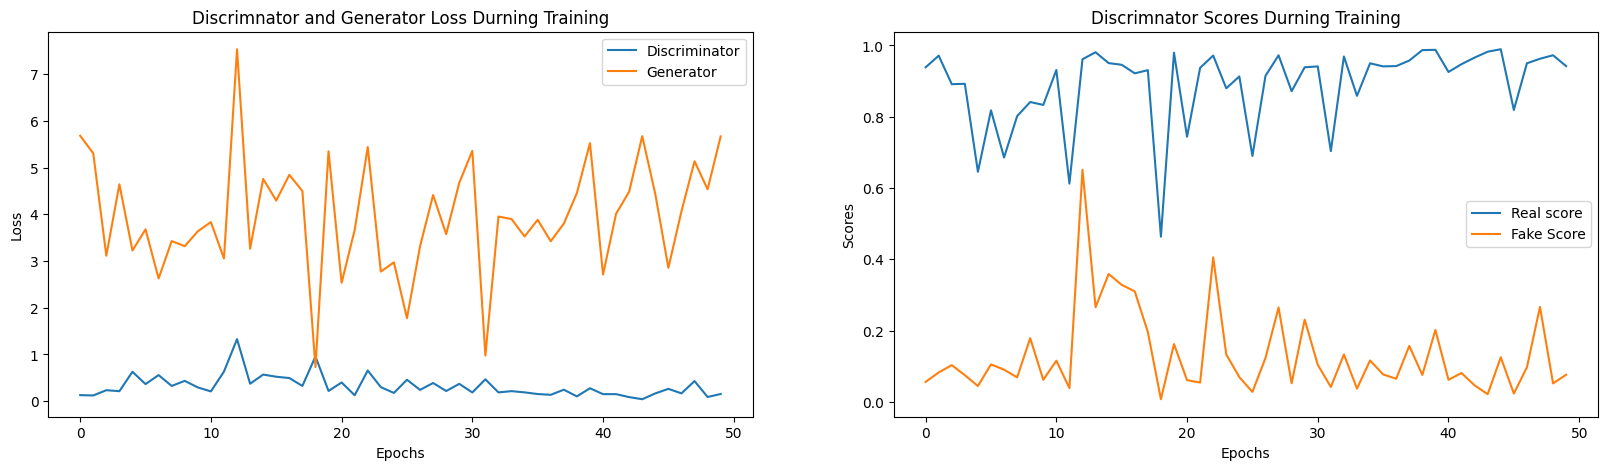

In [28]:
# ploting the loss and score curves
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(dis_losses, label='Discriminator')
plt.plot(gen_losses, label='Generator')
plt.title('Discrimnator and Generator Loss Durning Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(real_scores, label='Real score')
plt.plot(fake_scores, label='Fake Score')
plt.title('Discrimnator Scores Durning Training')
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.legend();

Watching both the plots, we can see that the Generator had a significant improvement durning the 15th epoch, both the plots show a deep stretch durning those epochs.

In the loss plot, discriminator at the end of the epochs shows sign of improving, so most likly if we train for more epochs then the generator will start to learn something new and create much better face images.

Now, lets visualize the sample data we collected

### Sample Visualization

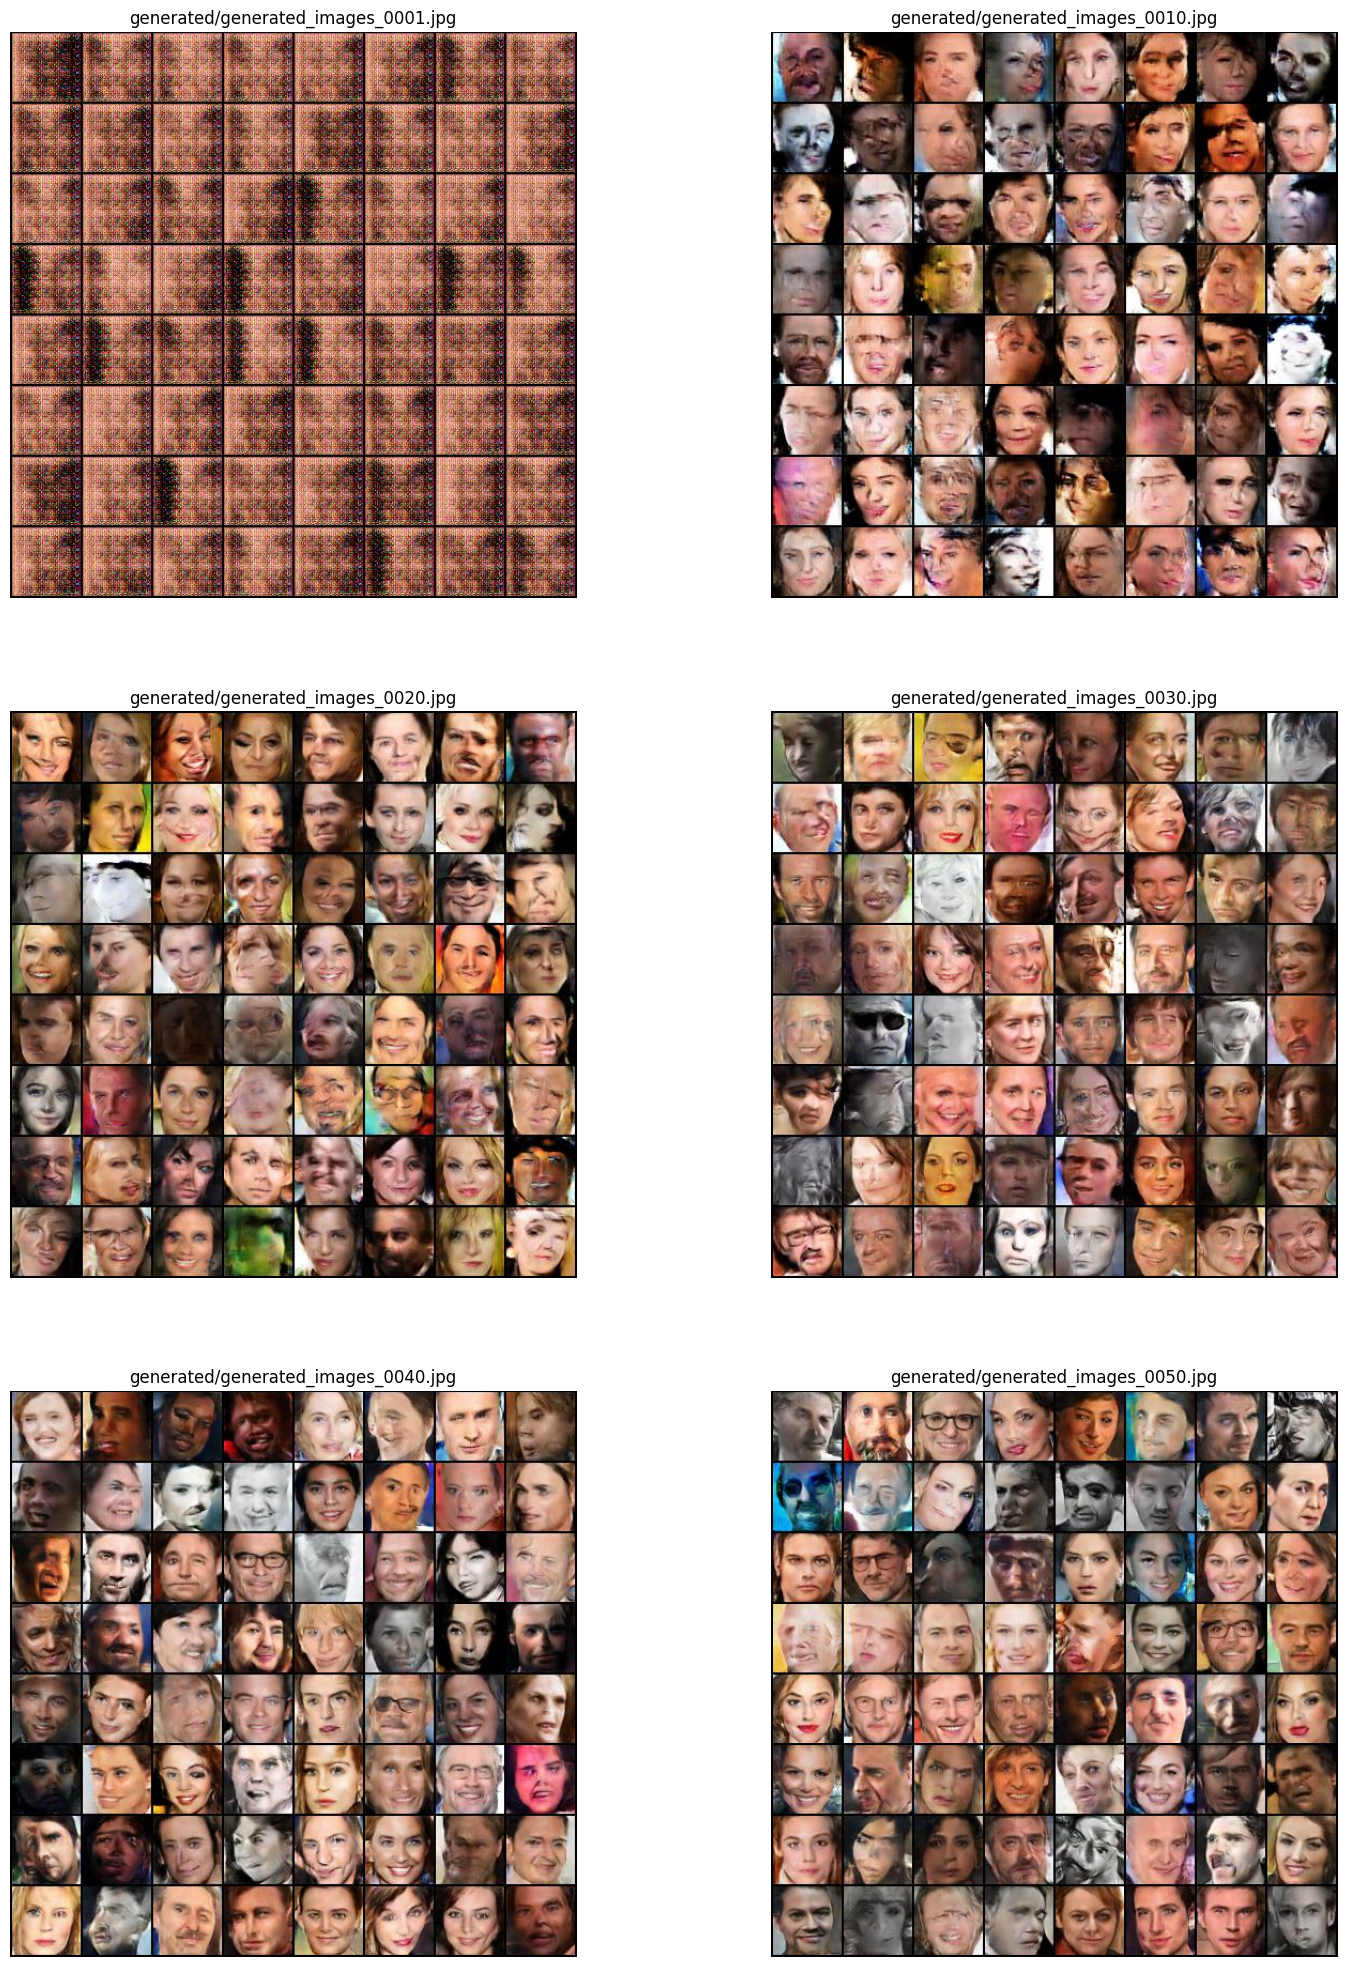

In [29]:
# Collecting generated images in a list
sample_img_list = [os.path.join(generator_img_dir, f) for f in os.listdir(generator_img_dir) if 'generated' in f]
sample_img_list.sort()

# Image visualiztion at every 10 epochs interval
img_index = [1, 10, 20, 30, 40, 50]
plt.figure(figsize=(18, 25))
for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.imshow(plt.imread(sample_img_list[img_index[i]]))
    plt.title(sample_img_list[img_index[i]])
    plt.axis(False)

In [ ]:
# Visualizing the sample data from directory 'generated'
matplotlib.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(8, 8))
plt.axis(False)
sample_img = [[plt.imshow(plt.imread(i), animated=True)] for i in sample_img_list]
sample_animation = animation.ArtistAnimation(fig, sample_img, interval=500, repeat_delay=1000, blit=True)
HTML(sample_animation.to_jshtml())

## Conclusion

In this project, we learn to produce face images using the Deep Convolutional General Adversarial Networks, we also build two specific neural network architecture - Discriminator and Generator.

This two core architectures are then trained onto each other where one supports and boost the other models performance. While we have only trained the model for 50 epochs in our first experiment, the model are already capable to produce face images with features like hair, nose, eyes, eyebrows, ears and skin tone.

Still, the model needs improvement where we can also see some limitations like face shape and skin color. We can imporve the model by running some more experiments like increasing the epochs, changing the learning rate and once the model has started to almost create perfect images we can work to increase the image resolution.